In [19]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from matplotlib.colorbar import Colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as pt
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import lightning as pL
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from torchsummary import summary
import torch_geometric as tg

In [2]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y, categoric_values):
    mi_scores = mutual_info_regression(X,y, discrete_features = categoric_values)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores,cmap = "autumn"):
    scores = scores.sort_values(ascending = False)
    graphic =  sns.heatmap(data = pd.DataFrame(scores.values.reshape(-1,1), index = scores.index),  annot = True, cbar = True, cmap = cmap)
    plt.title("Mutual Informarion Scores")
    plt.show()

In [3]:
Dataset = pd.read_csv("Stellar_Dataset2.csv")
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SOURCE_ID          50000 non-null  int64  
 1   ra                 50000 non-null  float64
 2   dec                50000 non-null  float64
 3   parallax           50000 non-null  float64
 4   pmra               50000 non-null  float64
 5   pmdec              50000 non-null  float64
 6   phot_g_mean_mag    50000 non-null  float64
 7   phot_bp_mean_mag   50000 non-null  float64
 8   phot_rp_mean_mag   50000 non-null  float64
 9   teff_gspphot       50000 non-null  float64
 10  logg_gspphot       50000 non-null  float64
 11  distance_gspphot   50000 non-null  float64
 12  ag_gspphot         50000 non-null  float64
 13  azero_gspphot      50000 non-null  float64
 14  mh_gspphot         50000 non-null  float64
 15  bp_rp              50000 non-null  float64
 16  bp_g               500

In [9]:
Train_Valid_Data, Test_Data = train_test_split(Dataset, test_size = 0.2, random_state = 42)
X_train_Valid_Data, y_train_Valid_Data = Train_Valid_Data.drop(columns = ["SOURCE_ID","radius_flame", "mass_flame", "age_flame", "lum_flame", "mh_gspphot_2"]), Train_Valid_Data[["radius_flame", "mass_flame", "age_flame", "lum_flame"]]
X_train_Valid_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 39087 to 15795
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ra                 40000 non-null  float64
 1   dec                40000 non-null  float64
 2   parallax           40000 non-null  float64
 3   pmra               40000 non-null  float64
 4   pmdec              40000 non-null  float64
 5   phot_g_mean_mag    40000 non-null  float64
 6   phot_bp_mean_mag   40000 non-null  float64
 7   phot_rp_mean_mag   40000 non-null  float64
 8   teff_gspphot       40000 non-null  float64
 9   logg_gspphot       40000 non-null  float64
 10  distance_gspphot   40000 non-null  float64
 11  ag_gspphot         40000 non-null  float64
 12  azero_gspphot      40000 non-null  float64
 13  mh_gspphot         40000 non-null  float64
 14  bp_rp              40000 non-null  float64
 15  bp_g               40000 non-null  float64
 16  g_rp               4000

C:\Users\kdarn\AppData\Local\Temp\ipykernel_10772\637639480.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("viridis")
C:\Users\kdarn\AppData\Local\Temp\ipykernel_10772\637639480.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(colorbar)


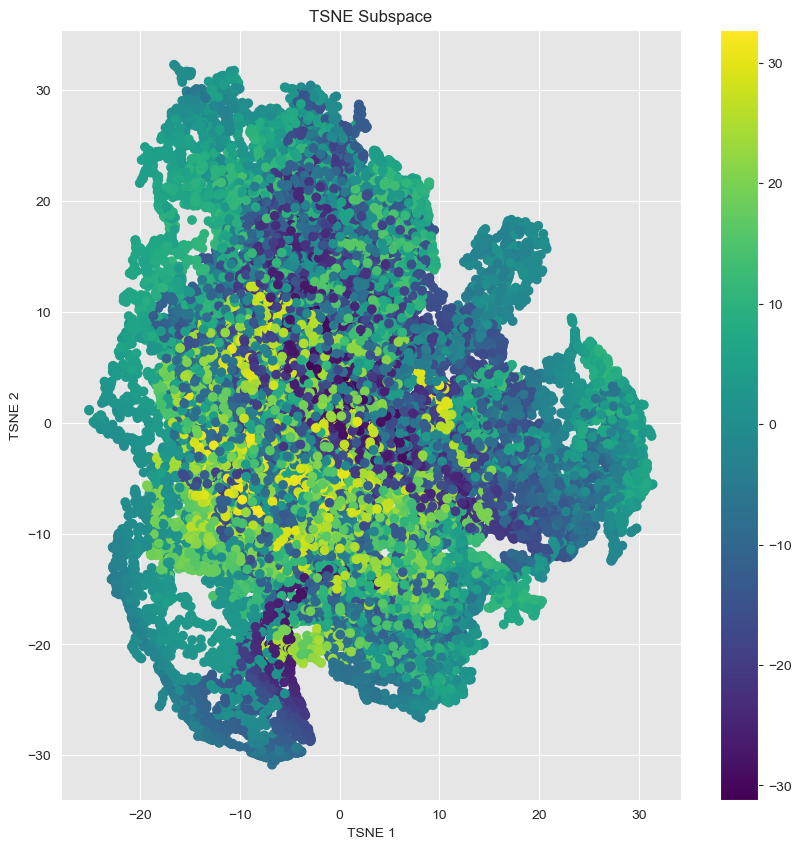

In [18]:
Subspace = TSNE(n_components= 3, learning_rate = "auto", init = "random", perplexity=30).fit_transform(X_train_Valid_Data)
plt.figure(figsize = (10,10))
cm = plt.cm.get_cmap("viridis")
colorbar = ScalarMappable(norm = Normalize(vmin = min(Subspace[:,2]), vmax = max(Subspace[:,2])), cmap = cm)
plt.scatter(Subspace[:,0], Subspace[:,1], c = Subspace[:,2], cmap = cm)
plt.colorbar(colorbar)
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE Subspace")
plt.show()

C:\Users\kdarn\AppData\Local\Temp\ipykernel_10772\3622043634.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("viridis")
C:\Users\kdarn\AppData\Local\Temp\ipykernel_10772\3622043634.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(colorbar)


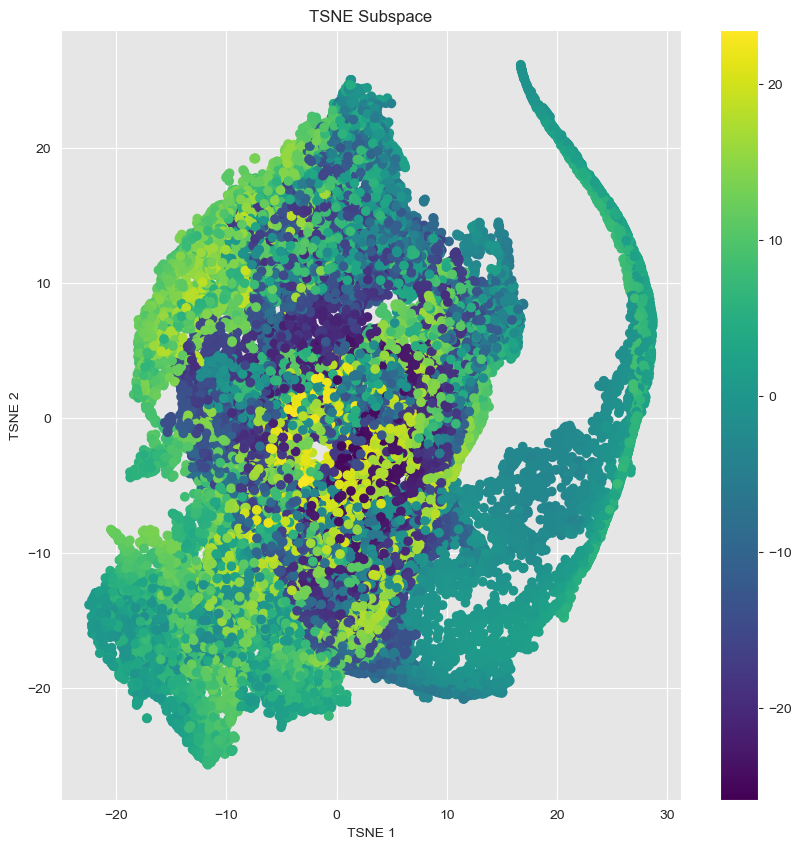

In [24]:
Subspace = TSNE(n_components= 3, learning_rate = "auto", init = "random", perplexity=50).fit_transform(X_train_Valid_Data)
plt.figure(figsize = (10,10))
cm = plt.cm.get_cmap("viridis")
colorbar = ScalarMappable(norm = Normalize(vmin = min(Subspace[:,2]), vmax = max(Subspace[:,2])), cmap = cm)
plt.scatter(Subspace[:,0], Subspace[:,1], c = Subspace[:,2], cmap = cm)
plt.colorbar(colorbar)
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE Subspace")
plt.show()

In [ ]:
Subspace = TSNE(n_components= 3, learning_rate = "auto", init = "random", perplexity=30).fit_transform(X_train_Valid_Data)
plt.figure(figsize = (10,10))
cm = plt.cm.get_cmap("viridis")
colorbar = ScalarMappable(norm = Normalize(vmin = min(Subspace[:,2]), vmax = max(Subspace[:,2])), cmap = cm)
plt.scatter(Subspace[:,0], Subspace[:,1], c = Subspace[:,2], cmap = cm)
plt.colorbar(colorbar)
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE Subspace")
plt.show()

C:\Users\kdarn\AppData\Local\Temp\ipykernel_10772\2712729175.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("hot")
C:\Users\kdarn\AppData\Local\Temp\ipykernel_10772\2712729175.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(colorbar)


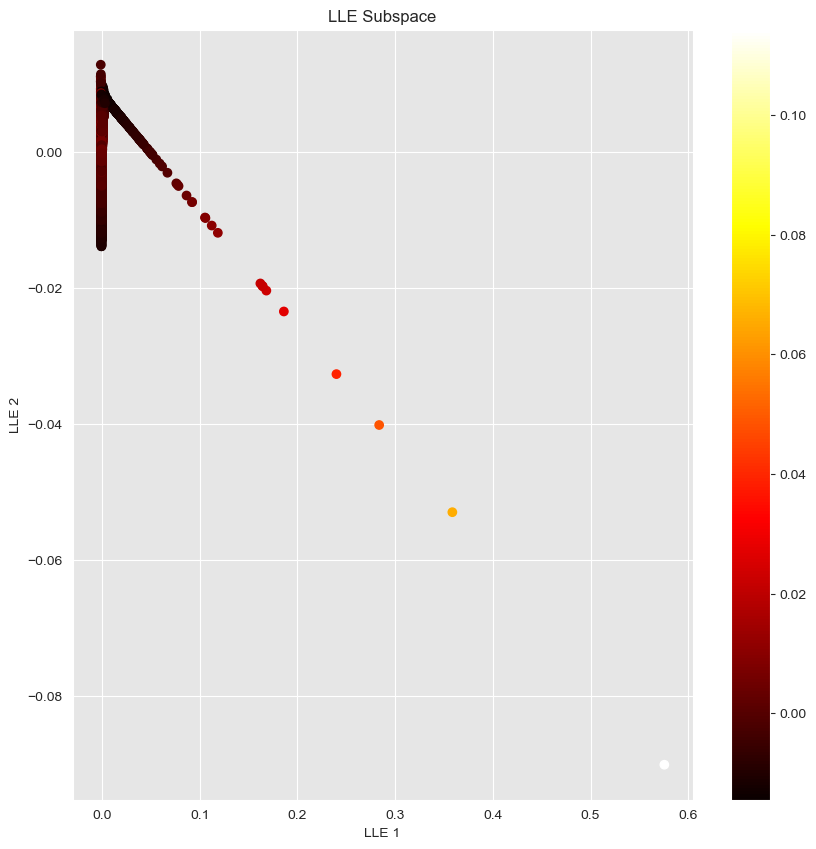

In [22]:
n_neighbors = 24 
n_components = 3
method = "standard"
Subspace = LocallyLinearEmbedding(n_neighbors = n_neighbors, n_components = n_components, method = method).fit_transform(X_train_Valid_Data)
plt.figure(figsize = (10,10))
cm = plt.cm.get_cmap("hot")
colorbar = ScalarMappable(norm = Normalize(vmin = min(Subspace[:,2]), vmax = max(Subspace[:,2])), cmap = cm)
plt.scatter(Subspace[:,0], Subspace[:,1], c = Subspace[:,2], cmap = cm)
plt.colorbar(colorbar)
plt.xlabel("LLE 1")
plt.ylabel("LLE 2")
plt.title("LLE Subspace")
plt.show()